# MAGMA experimnetations

## Artificial data : Common HP + Common grid

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel
from MAGMAfixed import MAGMA

### Data

In [2]:
N = 10
M = 5

t0 = 10
tN = 20 + 1e-3

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(10,)


In [3]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(10,)


In [4]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[46.02634902  2.43568772]


In [5]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(10, 10)


In [6]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(10,)


In [7]:
Theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
Sigma = np.random.uniform(0, 1)

print(Theta)
print(Sigma)

[120.72535867   2.73285289]
0.6057251048737569


In [8]:
C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta, common_T)
Psi_Theta_Sigma = C_Theta + Sigma * np.identity(N)

Y = np.zeros((M, N))
for i in range(M):
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(5, 10)


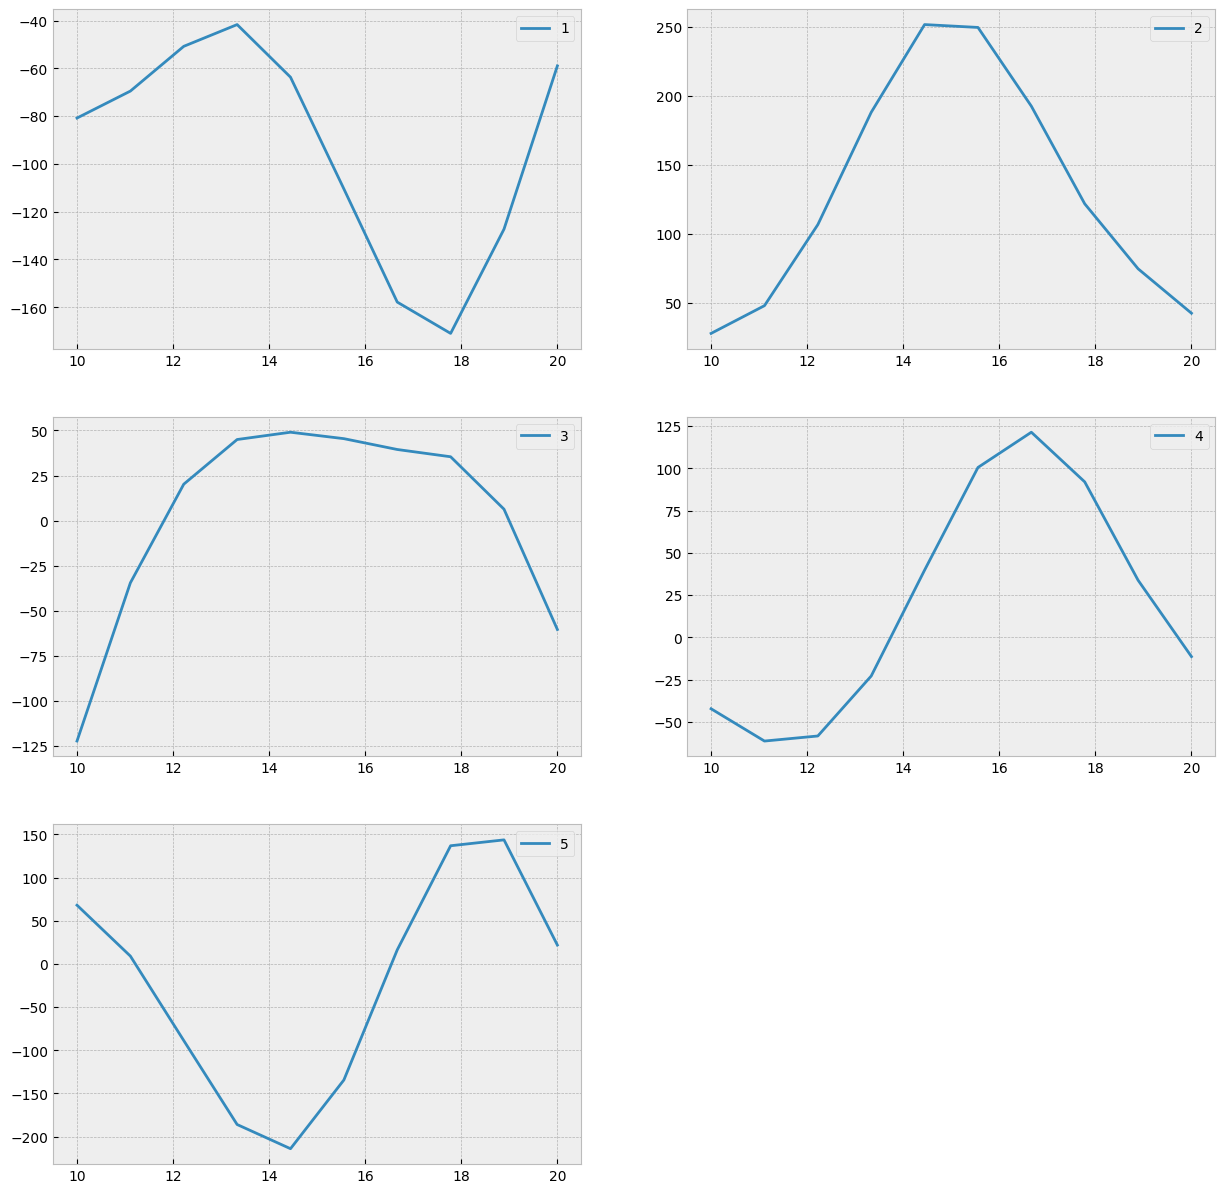

In [9]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(common_T, Y[i - 1], label=f"{i}")
    plt.legend()
plt.show()

### Model

#### Training

In [10]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(len(m0)),
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(0.98, 1.02), np.random.uniform(0.98, 1.02)]),
    Theta=np.array([np.random.uniform(0.98,1.02), np.random.uniform(0.98,1.02)]),
    Sigma=np.random.uniform(0.49,0.51),
    common_hp_flag=True,
    common_grid_flag=True,
    save_history_flag=True,
    scipy_optimize_display=True,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [11]:
model.fit(max_iterations=1, eps=1e-2)

MAGMA Training: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

theta0
Theta & Sigma


In [12]:
model.scipy_optimize_display = False
model.fit(max_iterations=49, eps=1e-2)

MAGMA Training:  71%|███████▏  | 35/49 [00:02<00:00, 16.32it/s]


In [13]:
history = model.history
len(history)

38

In [14]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

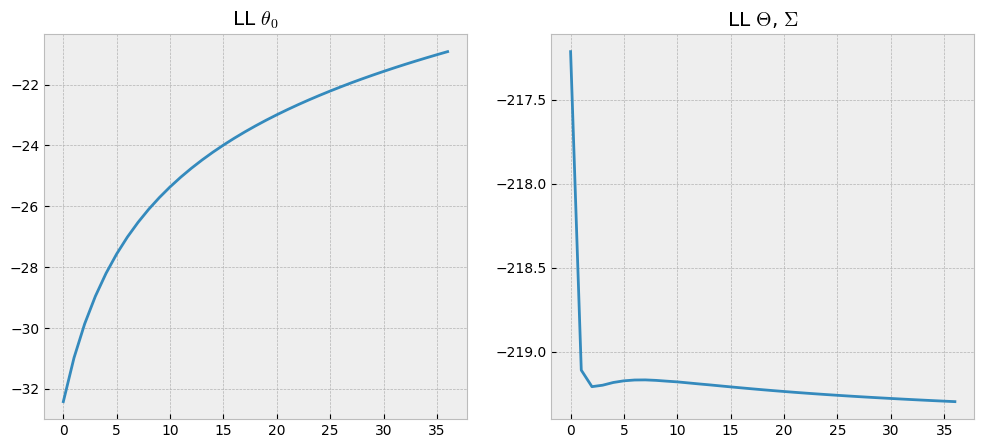

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [16]:
Sigma_estim = []
for epoch_history in history:
    Sigma_estim.append(epoch_history["Sigma"]**2)

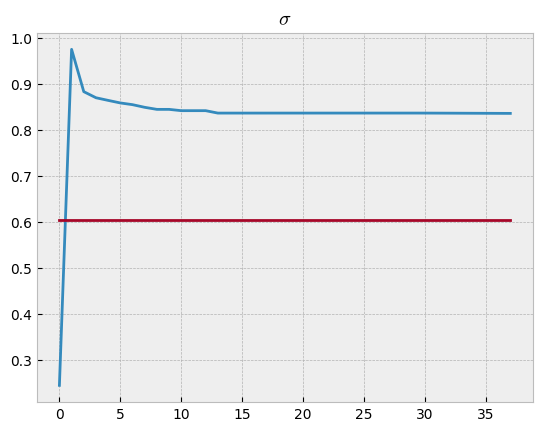

In [17]:
plt.plot(Sigma_estim,label="$\sigma$ predict")
plt.plot(Sigma*np.ones(len(Sigma_estim)),label="true $\sigma$")
plt.title("$\sigma$")
plt.show()

In [18]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

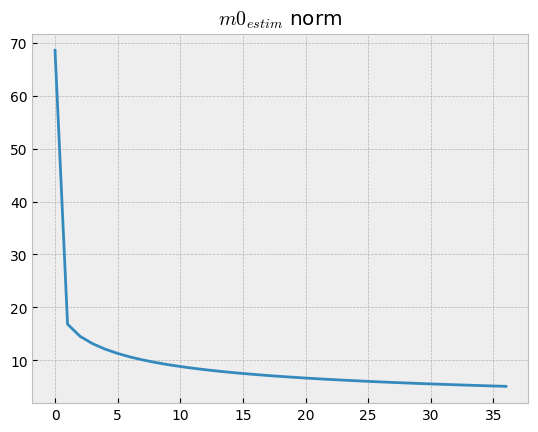

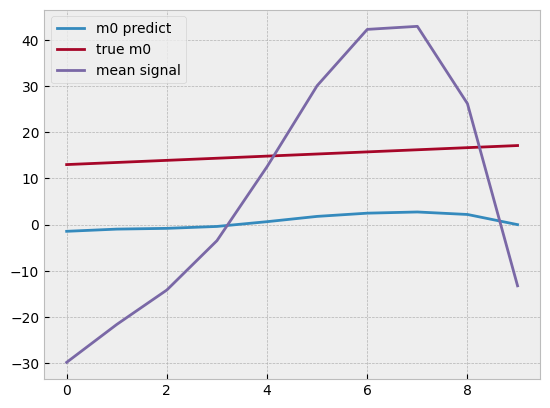

In [19]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()
plt.plot(history[-1]["m0"],label="m0 predict")
plt.plot(m0, label="true m0")
plt.plot(Y.mean(axis=0),label = "mean signal")
plt.legend()
plt.show()

In [20]:
theta0_predict = []
for epoch_history in history:
    theta0_predict.append(epoch_history["theta0"])
theta0_predict = np.array(theta0_predict)
print(model.theta0)

[14.50059253  2.54167652]


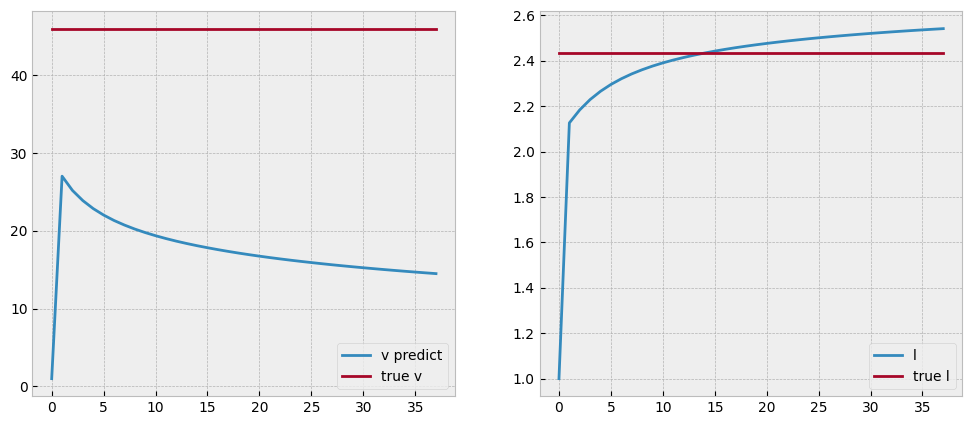

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0_predict[:, 0], label="v predict")
plt.plot(theta0[0]*np.ones(len(theta0_predict[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(theta0_predict[:, 1], label="l")
plt.plot(theta0[1]*np.ones(len(theta0_predict[:, 0])), label="true l")

plt.legend()
plt.show()

In [22]:
Theta_predict = []
for epoch_history in history:
    Theta_predict.append(epoch_history["Theta"])
Theta_predict = np.array(Theta_predict)
print(model.Theta)

[136.52195982   2.81914506]


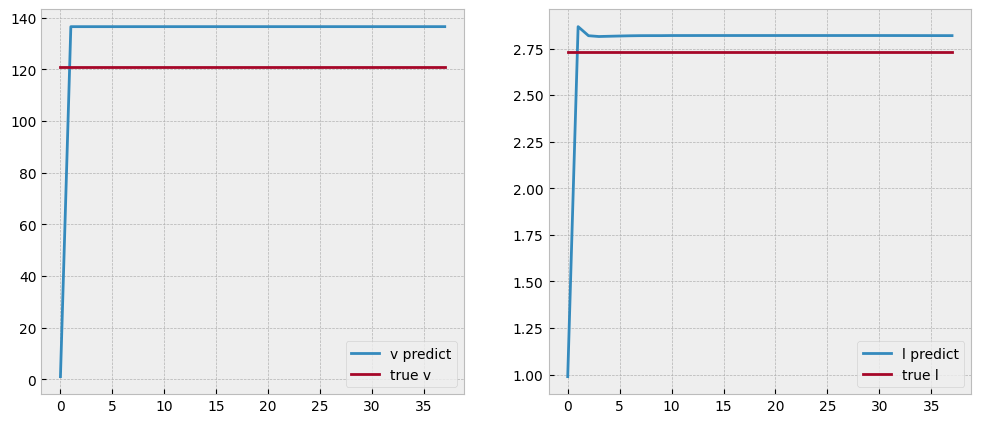

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(Theta_predict[:, 0], label="v predict")
plt.plot(Theta[0]*np.ones(len(Theta_predict[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Theta_predict[:, 1], label="l predict")
plt.plot(Theta[1]*np.ones(len(Theta_predict[:, 0])), label="true l")
plt.legend()
plt.show()

#### Prediction

##### Type II

In [50]:
tObs = 0
tP = 5
T_obs = np.linspace(tObs, tP-1e-3, N)
m_obs = m0_function(T_obs)
Cov_obs = ExponentiatedQuadraticKernel.compute_all(Theta, T_obs) + Sigma * np.identity(N)
Y_obs = np.random.multivariate_normal(m_obs, Cov_obs)
T_p = np.linspace(tP, t0-1e-3, N)
m_P = m0_function(T_p)
Cov_P = ExponentiatedQuadraticKernel.compute_all(Theta, T_p) + Sigma * np.identity(N)
Y_p = np.random.multivariate_normal(m_P, Cov_P)

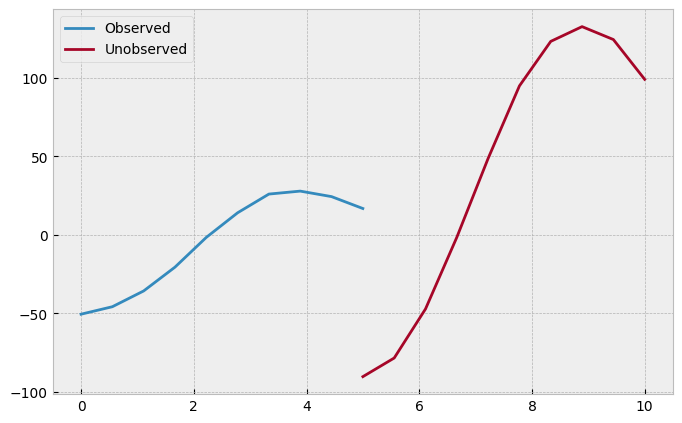

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(T_obs, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [52]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_p, Y_p)

n_p: 10
n_obs 10
Rho_p_obs: (20, 20)
Rho_p: (10, 10)
Rho_obs: (10, 10)
Rho_pobs: (10, 10)
Rho_obsp: (10, 10)


In [53]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

1537.7881222833105

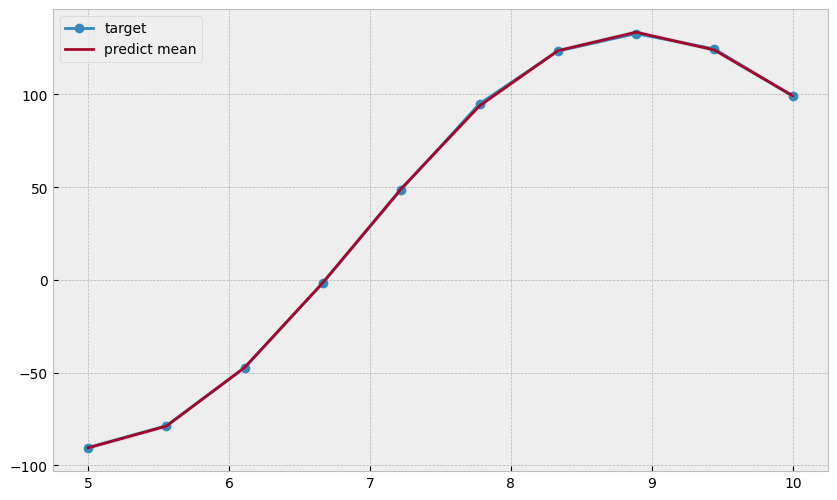

In [54]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

In [55]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_obs, Y_obs)

n_p: 10
n_obs 10
Rho_p_obs: (20, 20)
Rho_p: (10, 10)
Rho_obs: (10, 10)
Rho_pobs: (10, 10)
Rho_obsp: (10, 10)


In [56]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

55.69024462018755

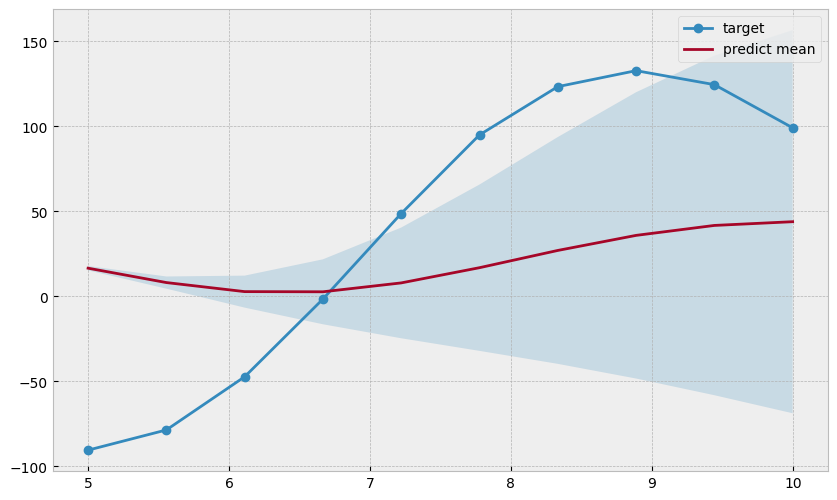

In [57]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

##### Type I

In [47]:
Y_obs = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
T_p = np.linspace(tP, t0-1e-3, N)
m_P = m0_function(T_p)
Cov_P = ExponentiatedQuadraticKernel.compute_all(Theta, T_p) + Sigma * np.identity(N)
Y_p = np.random.multivariate_normal(m_P, Cov_P)

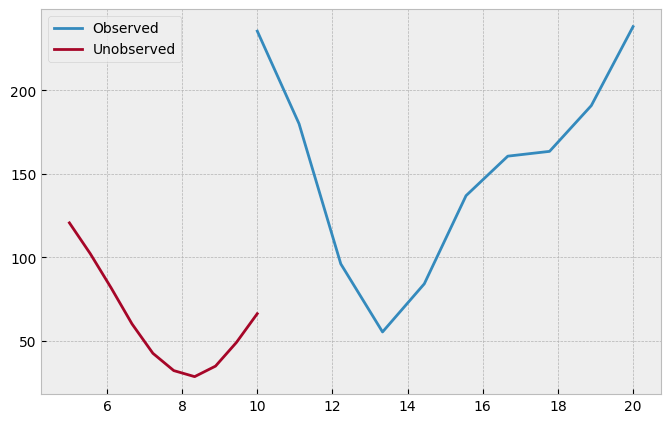

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(common_T, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [ ]:
m_P_predict, Cov_P_predict = model.predict(T_p, common_, Y_p)